In [3]:
if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import pickle
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from aux_funcs import colored_line, compressed_read
from imblearn.under_sampling import RandomUnderSampler
# from aux_funcs import parse_string_with_regex, ordered_colors_from_cmap

N_ENVS = 30

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 3.0

In [4]:
def load_numpy(data_path, averaging_size=1):
    file_names = glob.glob(data_path)
    data = []
    for file_name in file_names:
        data_for_file = np.load(file_name)
        data.append(data_for_file)
    data = np.concatenate(data, axis=1)
    if averaging_size == 1:
        return data
    reduced_data = np.empty((data.shape[0], int(data.shape[1] / averaging_size)))
    for k in range(0, int(data.shape[1] / averaging_size) * averaging_size, averaging_size):
        reduced_data[:, int(k / averaging_size)] = data[:, k:k + averaging_size].mean(axis=1)
    return reduced_data

def load_data(data_path, indices=[]):
#     file_names = glob.glob(data_path)
    file_names = sorted(os.listdir(data_path))
    print(file_names)
    for fidx, file_name in enumerate(file_names):
        if fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)):
            data_for_file = pickle.load(open(os.path.join(data_path, file_name), 'rb'))
            yield data_for_file

def load_compressed_data(data_path, indices=[], all=False):
    file_names = sorted(os.listdir(data_path))
    print(file_names)

    
    for fidx, file_name in enumerate(file_names):
        if fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)) or all:
            data_for_file = compressed_read(os.path.join(data_path, file_name))
            yield data_for_file

def parse_session(data_path, update_num=None):
    indices = [] if update_num is None else [update_num]
    state_data = load_compressed_data(
        data_path,
        all=True,
    )

    features = [
        'current_patch_num',
        'reward_site_idx',
        'current_reward_site_attempted',
        'agent_in_patch',
        'patch_reward_param',
        'action',
        'reward',
    ]

    all_time_series_dicts = []

    for d in state_data:
        for env_idx in range(N_ENVS):
            features_to_time_series_dict = {}
            for f in features:
                features_to_time_series_dict[f] = np.zeros((len(d)), dtype=float)
            
            for k in np.arange(len(d)):
                for f in features:
                    features_to_time_series_dict[f][k] = d[k][f][env_idx]

        
            dwell_time = np.zeros((len(d)))
            rewards_seen_in_patch = np.zeros((len(d)))
            
            for idx in np.arange(0, len(d)):
                if idx > 0 and features_to_time_series_dict['action'][idx] == 0:
                    dwell_time[idx] = dwell_time[idx-1] + 1
                else:
                    dwell_time[idx] = 0

                if features_to_time_series_dict['agent_in_patch'][idx]:
                    if idx > 0:
                        rewards_seen_in_patch[idx] = rewards_seen_in_patch[idx-1] + features_to_time_series_dict['reward'][idx]
                    else:
                        rewards_seen_in_patch[idx] = features_to_time_series_dict['reward'][idx]
        
            features_to_time_series_dict['dwell_time'] = dwell_time
            features_to_time_series_dict['rewards_seen_in_patch'] = rewards_seen_in_patch
            all_time_series_dicts.append(features_to_time_series_dict)
        
    return all_time_series_dicts

def find_patch_trajectories(agent_in_patch_ts):
    starts_and_stops = []
    start_idx = None
    for k in np.arange(len(agent_in_patch_ts)):
        if agent_in_patch_ts[k] > 0:
            if start_idx is None:
                start_idx = k
        elif (k > 0 and agent_in_patch_ts[k-1] > 0 and start_idx is not None):
            starts_and_stops.append(slice(start_idx, k))
            start_idx = None
    return starts_and_stops

def find_odor_site_trajectories(odor_site_indices, site_num=None):
    starts_and_stops = []
    start_idx = None
    for k in np.arange(len(odor_site_indices)):
        if (site_num is None and odor_site_indices[k] >= 0) or \
            odor_site_indices[k] == site_num:
            if start_idx is None:
                start_idx = k
        elif k > 0 and \
            ((odor_site_indices[k-1] >= 0 and site_num is None) or odor_site_indices[k-1] == site_num) and \
            start_idx is not None:
            starts_and_stops.append(slice(start_idx, k))
            start_idx = None
    return starts_and_stops

def find_trajectories_by_patch_type(session_data):
    patch_starts_and_ends = find_patch_trajectories(session_data['agent_in_patch'])
    trajs_by_patch_type = [[], [], []]
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        patch_num = int(session_data['current_patch_num'][patch_traj_indices][0])
        trajs_by_patch_type[patch_num].append(patch_traj_indices)
    return trajs_by_patch_type

def find_odor_site_trajectories_by_patch_type(session_data, first_site_only=False, site_num=None):
    if first_site_only:
        site_num = 0
    patch_starts_and_ends = find_odor_site_trajectories(session_data['reward_site_idx'], site_num=site_num)
    trajs_by_patch_type = [[], [], []]
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        patch_num = int(session_data['current_patch_num'][patch_traj_indices][0])
        trajs_by_patch_type[patch_num].append(patch_traj_indices)
    return trajs_by_patch_type

In [22]:
p = 'acc_reward_test_he_005k_01_2025-02-11_13_11_05_501531_var_noise_0_activity_weight_0'

data = load_numpy(f'../../results/rl_agent_outputs/{p}/hidden_state/*.npy')
all_session_data = parse_session(f'../../results/rl_agent_outputs/{p}/state')
all_session_data = np.array(all_session_data)
print(all_session_data.shape)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
(210,)


In [6]:
hidden_states = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                hidden_states.append(data[curr_traj, env_idx, :])
                targets.append(np.array([
                    session_data['reward_site_idx'][curr_traj],
                    session_data['rewards_seen_in_patch'][curr_traj],
                    session_data['patch_reward_param'][curr_traj],
                ]))

hidden_states = np.concatenate(hidden_states, axis=0)
targets = np.concatenate(targets, axis=1).T

first_site_hidden_states = []
first_site_targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data, first_site_only=True)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                first_site_hidden_states.append(data[curr_traj, env_idx, :])
                first_site_targets.append(np.array([
                    session_data['patch_reward_param'][curr_traj],
                ]))

first_site_hidden_states = np.concatenate(first_site_hidden_states, axis=0)
first_site_targets = np.concatenate(first_site_targets, axis=1).T

[-0.6617538814002581, -0.5504459545057412, -0.35440174813297687, -0.3825919349857252, -0.35826846859427497]
[-0.5869100244395795, -0.5257024113519628, -0.46024329860860647, -0.45762119642191257, -0.4126169246036373]
[0.4053975938437082, 0.4070233751219336, 0.40919847535090415, 0.40800621420958505, 0.4086565384684864]
[0.3852391391462179, 0.38662989416118615, 0.3901984819197586, 0.38449389467729006, 0.3892084295884211]


(0.0, 1.1)

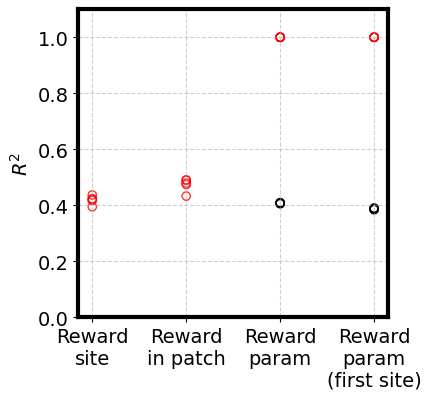

In [7]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

reg_types = [
    LinearRegression,
    LinearRegression,
    LogisticRegression,
]

for k in range(targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(hidden_states, y):
        # do normal regression
        if k == 2:
            classifier = reg_types[k](max_iter=int(1e6))
        else:
            classifier = reg_types[k]()
        reg = classifier.fit(hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(hidden_states[test_i, :], y_test))

    
    all_pred_accuracies.append(pred_accuracies)
    axs.scatter(np.ones(5) * k, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(np.ones(5) * k, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')

for k in range(first_site_targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = first_site_targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(first_site_hidden_states, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(first_site_hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y_test))

    all_pred_accuracies.append(pred_accuracies)
    x = np.ones(5) * k + targets.shape[1]
    axs.scatter(x, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(x, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel(r'$R^2$')
axs.set_xticks(np.arange(targets.shape[1] + first_site_targets.shape[1]))
axs.set_xticklabels([
    'Reward\nsite',
    'Reward\nin patch',
    'Reward\nparam',
    'Reward\nparam\n(first site)',
])
axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [8]:
covariates = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]

        reward_history = []
        for i in range(len(trajs_for_patch_type)):
            curr_traj = trajs_for_patch_type[i]

            reward_site_idx = session_data['reward_site_idx'][curr_traj][0]

            if reward_site_idx == 0:
                reward_history = []

            attempted = session_data['current_reward_site_attempted'][curr_traj].sum() > 0
            reward = session_data['reward'][curr_traj].sum()
            if len(reward_history) > 29:
                reward_history = reward_history[:30]
            reward_history_vec = np.concatenate([np.array(reward_history), np.zeros(30 - len(reward_history))])

            covariates.append(np.concatenate([
                [session_data['current_patch_num'][curr_traj][0]],
                reward_history_vec,
            ]))
            
            targets.append(attempted)
            reward_history.insert(0, reward)

covariates = np.stack(covariates)
targets = np.array(targets).reshape((len(targets), 1)).astype(int)

sampler = RandomUnderSampler()
covariates, targets = sampler.fit_resample(covariates, targets)
targets = targets.reshape(targets.shape[0], 1)

print(covariates.shape)
print(targets.shape)

(89698, 31)
(89698, 1)


(0.0, 1.1)

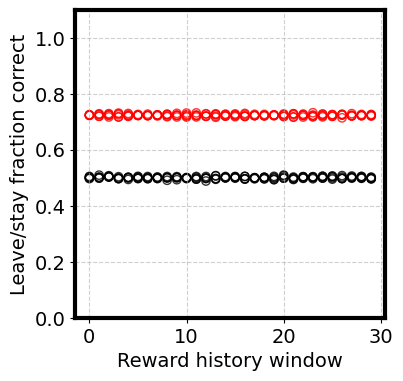

In [9]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    for reward_hist_size in range(0, 30):
        kf = KFold(n_splits=5, shuffle=True)
        pred_accuracies = []
        shuffled_pred_accuracies = []
        for train_i, test_i in kf.split(covariates, y):
            classifier = LogisticRegression(max_iter=int(1e6))
            reg = classifier.fit(covariates[train_i, :reward_hist_size + 1], y[train_i])
            pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y[test_i]))
            # do regression with shuffled labels
            y_test = y[test_i]
            np.random.shuffle(y_test)
            shuffled_pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y_test))

    
        axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
        axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [23]:
covariates = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]

        reward_history = []
        for i in range(len(trajs_for_patch_type)):
            curr_traj = trajs_for_patch_type[i]

            reward_site_idx = session_data['reward_site_idx'][curr_traj][0]

            if reward_site_idx == 0:
                reward_history = []

            attempted = session_data['current_reward_site_attempted'][curr_traj].sum() > 0
            reward = session_data['reward'][curr_traj].sum()
            if len(reward_history) > 29:
                reward_history = reward_history[:30]
            reward_history_vec = np.concatenate([np.array(reward_history), np.zeros(30 - len(reward_history))])

            covariates.append(np.concatenate([
                [session_data['current_patch_num'][curr_traj][0]],
                [reward_site_idx],
                reward_history_vec,
            ]))
            
            targets.append(attempted)
            reward_history.insert(0, reward)

covariates = np.stack(covariates)
targets = np.array(targets).reshape((len(targets), 1)).astype(int)

targets = targets[covariates[:, 0] > 0]
covariates = covariates[covariates[:, 0] > 0, :]

sampler = RandomUnderSampler()
covariates, targets = sampler.fit_resample(covariates, targets)
targets = targets.reshape(targets.shape[0], 1)

print(covariates.shape)
print(targets.shape)

(59944, 32)
(59944, 1)


(0.0, 1.1)

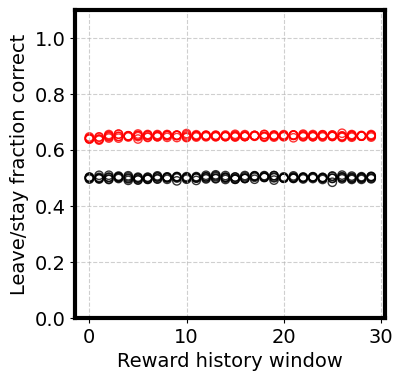

In [24]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    for reward_hist_size in range(0, 30):
        kf = KFold(n_splits=5, shuffle=True)
        pred_accuracies = []
        shuffled_pred_accuracies = []
        for train_i, test_i in kf.split(covariates, y):
            classifier = LogisticRegression(max_iter=int(1e6))
            reg = classifier.fit(covariates[train_i, :reward_hist_size + 1], y[train_i])
            pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y[test_i]))
            # do regression with shuffled labels
            y_test = y[test_i]
            np.random.shuffle(y_test)
            shuffled_pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y_test))

    
        axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
        axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)
    

In [26]:
covariates = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]

        reward_history = []
        for i in range(len(trajs_for_patch_type)):
            curr_traj = trajs_for_patch_type[i]

            reward_site_idx = session_data['reward_site_idx'][curr_traj][0]

            if reward_site_idx == 0:
                reward_history = []

            attempted = session_data['current_reward_site_attempted'][curr_traj].sum() > 0
            reward = session_data['reward'][curr_traj].sum()
            if len(reward_history) > 29:
                reward_history = reward_history[:30]
            reward_history_vec = np.concatenate([np.array(reward_history), np.zeros(30 - len(reward_history))]).sum()

            covariates.append(np.concatenate([
                [session_data['current_patch_num'][curr_traj][0]],
                [reward_history_vec],
            ]))
            
            targets.append(attempted)
            reward_history.insert(0, reward)

covariates = np.stack(covariates)
targets = np.array(targets).reshape((len(targets), 1)).astype(int)

sampler = RandomUnderSampler()
covariates, targets = sampler.fit_resample(covariates, targets)
targets = targets.reshape(targets.shape[0], 1)

print(covariates.shape)
print(targets.shape)

(89698, 2)
(89698, 1)


(0.0, 1.1)

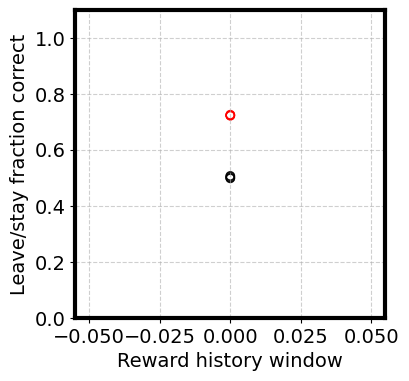

In [27]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    for reward_hist_size in range(0, 1):
        kf = KFold(n_splits=5, shuffle=True)
        pred_accuracies = []
        shuffled_pred_accuracies = []
        for train_i, test_i in kf.split(covariates, y):
            classifier = LogisticRegression(max_iter=int(1e6))
            reg = classifier.fit(covariates[train_i, :reward_hist_size + 1], y[train_i])
            pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y[test_i]))
            # do regression with shuffled labels
            y_test = y[test_i]
            np.random.shuffle(y_test)
            shuffled_pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y_test))

    
        axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
        axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [12]:
covariates = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]

        reward_history = []
        for i in range(len(trajs_for_patch_type)):
            curr_traj = trajs_for_patch_type[i]

            attempted = session_data['current_reward_site_attempted'][curr_traj].sum() > 0
            covariates.append(data[curr_traj, env_idx, :][0, :])
            targets.append(attempted)

covariates = np.stack(covariates)
targets = np.array(targets).reshape((len(targets), 1)).astype(int)

sampler = RandomUnderSampler()
covariates, targets = sampler.fit_resample(covariates, targets)
targets = targets.reshape(targets.shape[0], 1)

print(covariates.shape)
print(targets.shape)

(89698, 128)
(89698, 1)


(0.0, 1.1)

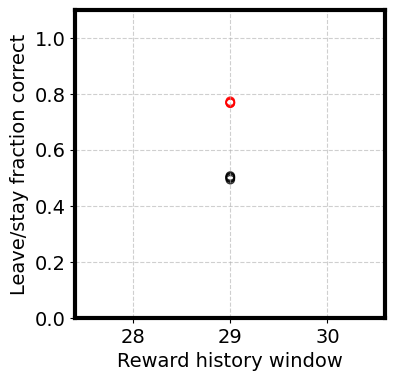

In [13]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    kf = KFold(n_splits=5, shuffle=True)
    pred_accuracies = []
    shuffled_pred_accuracies = []
    for train_i, test_i in kf.split(covariates, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(covariates[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(covariates[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(covariates[test_i, :], y_test))


    axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [14]:
p = 'acc_reward_test_he_010k_01_2025-02-11_13_35_37_313572_var_noise_0_activity_weight_0'

data = load_numpy(f'../../results/rl_agent_outputs/{p}/hidden_state/*.npy')
all_session_data = parse_session(f'../../results/rl_agent_outputs/{p}/state')
all_session_data = np.array(all_session_data)
print(all_session_data.shape)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
(210,)


In [15]:
hidden_states = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                hidden_states.append(data[curr_traj, env_idx, :])
                targets.append(np.array([
                    session_data['reward_site_idx'][curr_traj],
                    session_data['rewards_seen_in_patch'][curr_traj],
                    session_data['patch_reward_param'][curr_traj],
                ]))

hidden_states = np.concatenate(hidden_states, axis=0)
targets = np.concatenate(targets, axis=1).T

first_site_hidden_states = []
first_site_targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data, first_site_only=True)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                first_site_hidden_states.append(data[curr_traj, env_idx, :])
                first_site_targets.append(np.array([
                    session_data['patch_reward_param'][curr_traj],
                ]))

first_site_hidden_states = np.concatenate(first_site_hidden_states, axis=0)
first_site_targets = np.concatenate(first_site_targets, axis=1).T

[-0.6949193738581458, -0.7122889604816793, -0.5701253359815068, -0.8522932728190646, -0.8212575212784397]
[-0.7229552021887085, -0.718107048089458, -0.6044393518316695, -0.7551699648765098, -0.7232618491648395]
[0.41118705897525654, 0.4128452198905614, 0.4115923871989977, 0.41407962857195496, 0.41303706979143634]
[0.3848213158227049, 0.3837605758302816, 0.3893420886475565, 0.3850233615355474, 0.39146356863240306]


(0.0, 1.1)

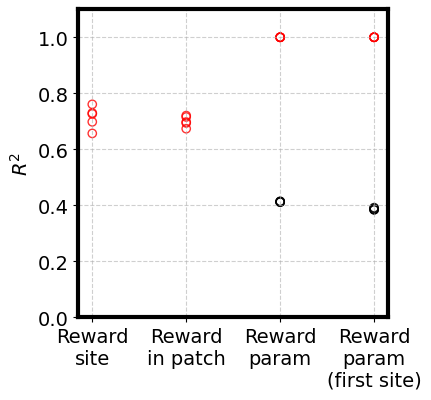

In [16]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

reg_types = [
    LinearRegression,
    LinearRegression,
    LogisticRegression,
]

for k in range(targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(hidden_states, y):
        # do normal regression
        if k == 2:
            classifier = reg_types[k](max_iter=int(1e6))
        else:
            classifier = reg_types[k]()
        reg = classifier.fit(hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(hidden_states[test_i, :], y_test))

    
    all_pred_accuracies.append(pred_accuracies)
    axs.scatter(np.ones(5) * k, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(np.ones(5) * k, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')

for k in range(first_site_targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = first_site_targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(first_site_hidden_states, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(first_site_hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y_test))

    all_pred_accuracies.append(pred_accuracies)
    x = np.ones(5) * k + targets.shape[1]
    axs.scatter(x, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(x, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel(r'$R^2$')
axs.set_xticks(np.arange(targets.shape[1] + first_site_targets.shape[1]))
axs.set_xticklabels([
    'Reward\nsite',
    'Reward\nin patch',
    'Reward\nparam',
    'Reward\nparam\n(first site)',
])
axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [17]:
covariates = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]

        reward_history = []
        for i in range(len(trajs_for_patch_type)):
            curr_traj = trajs_for_patch_type[i]

            reward_site_idx = session_data['reward_site_idx'][curr_traj][0]

            if reward_site_idx == 0:
                reward_history = []

            attempted = session_data['current_reward_site_attempted'][curr_traj].sum() > 0
            reward = session_data['reward'][curr_traj].sum()
            if len(reward_history) > 29:
                reward_history = reward_history[:30]
            reward_history_vec = np.concatenate([np.array(reward_history), np.zeros(30 - len(reward_history))])

            covariates.append(np.concatenate([
                [session_data['current_patch_num'][curr_traj][0]],
                reward_history_vec,
            ]))
            
            targets.append(attempted)
            reward_history.insert(0, reward)

covariates = np.stack(covariates)
targets = np.array(targets).reshape((len(targets), 1)).astype(int)

targets = targets[covariates[:, 0] > 0]
covariates = covariates[covariates[:, 0] > 0, :]

sampler = RandomUnderSampler()
covariates, targets = sampler.fit_resample(covariates, targets)
targets = targets.reshape(targets.shape[0], 1)

print(covariates.shape)
print(targets.shape)

(55922, 31)
(55922, 1)


(0.0, 1.1)

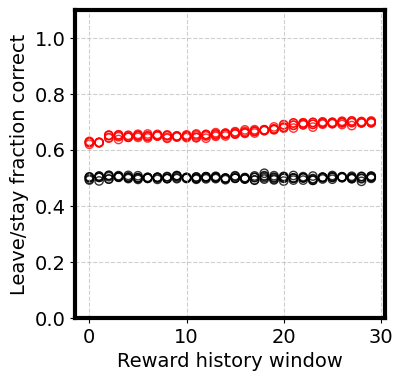

In [18]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    for reward_hist_size in range(0, 30):
        kf = KFold(n_splits=5, shuffle=True)
        pred_accuracies = []
        shuffled_pred_accuracies = []
        for train_i, test_i in kf.split(covariates, y):
            classifier = LogisticRegression(max_iter=int(1e6))
            reg = classifier.fit(covariates[train_i, :reward_hist_size + 1], y[train_i])
            pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y[test_i]))
            # do regression with shuffled labels
            y_test = y[test_i]
            np.random.shuffle(y_test)
            shuffled_pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y_test))

    
        axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
        axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [20]:
covariates = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]

        reward_history = []
        for i in range(len(trajs_for_patch_type)):
            curr_traj = trajs_for_patch_type[i]

            attempted = session_data['current_reward_site_attempted'][curr_traj].sum() > 0
            covariates.append(data[curr_traj, env_idx, :][0, :])
            targets.append(attempted)

covariates = np.stack(covariates)
targets = np.array(targets).reshape((len(targets), 1)).astype(int)

sampler = RandomUnderSampler()
covariates, targets = sampler.fit_resample(covariates, targets)
targets = targets.reshape(targets.shape[0], 1)

print(covariates.shape)
print(targets.shape)

(84270, 128)
(84270, 1)


(0.0, 1.1)

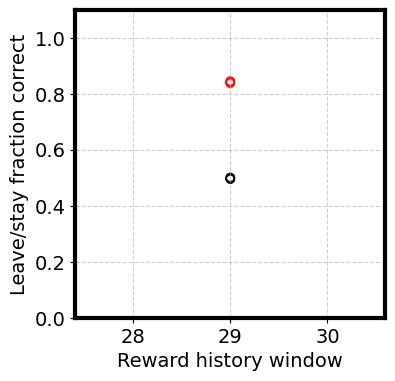

In [21]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    kf = KFold(n_splits=5, shuffle=True)
    pred_accuracies = []
    shuffled_pred_accuracies = []
    for train_i, test_i in kf.split(covariates, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(covariates[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(covariates[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(covariates[test_i, :], y_test))


    axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [ ]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    kf = KFold(n_splits=5, shuffle=True)
    pred_accuracies = []
    shuffled_pred_accuracies = []
    for train_i, test_i in kf.split(covariates, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(covariates[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(covariates[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(covariates[test_i, :], y_test))


    axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [31]:
data = load_numpy('../../results/rl_agent_outputs/acc_reward_test_he_130k_01_2025-02-11_13_58_08_176805_var_noise_0_activity_weight_0/hidden_state/*.npy')
all_session_data = parse_session('../../results/rl_agent_outputs/acc_reward_test_he_130k_01_2025-02-11_13_58_08_176805_var_noise_0_activity_weight_0/state')
all_session_data = np.array(all_session_data)
print(all_session_data.shape)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
(210,)


In [44]:
hidden_states = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                hidden_states.append(data[curr_traj, env_idx, :])
                targets.append(np.array([
                    session_data['reward_site_idx'][curr_traj],
                    session_data['rewards_seen_in_patch'][curr_traj],
                    session_data['patch_reward_param'][curr_traj],
                ]))

hidden_states = np.concatenate(hidden_states, axis=0)
targets = np.concatenate(targets, axis=1).T

first_site_hidden_states = []
first_site_targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data, first_site_only=True)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                first_site_hidden_states.append(data[curr_traj, env_idx, :])
                first_site_targets.append(np.array([
                    session_data['patch_reward_param'][curr_traj],
                ]))

first_site_hidden_states = np.concatenate(first_site_hidden_states, axis=0)
first_site_targets = np.concatenate(first_site_targets, axis=1).T

[-0.9289922699247541, -0.9691834427429953, -0.9218960398134335, -0.9049022316536424, -0.9355494809410654]
[-0.9533081907304841, -0.9501201020579213, -0.939570523361346, -0.8985853580998089, -0.955624224763868]
[0.4015431870327881, 0.4037080897046851, 0.40241284878987493, 0.4036895862630449, 0.40603952335134336]
[0.3929367276656088, 0.3882548900443424, 0.3927566569878677, 0.3883224165484953, 0.38827739887906004]


(0.0, 1.1)

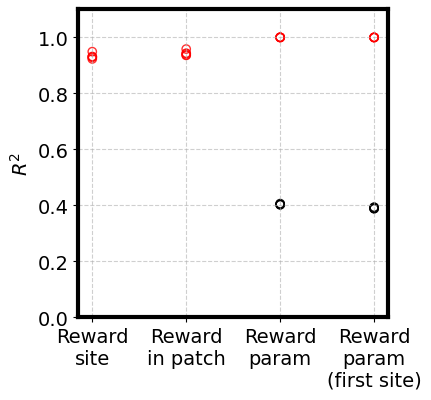

In [13]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

reg_types = [
    LinearRegression,
    LinearRegression,
    LogisticRegression,
]

for k in range(targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(hidden_states, y):
        # do normal regression
        if k == 2:
            classifier = reg_types[k](max_iter=int(1e6))
        else:
            classifier = reg_types[k]()
        reg = classifier.fit(hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(hidden_states[test_i, :], y_test))

    
    all_pred_accuracies.append(pred_accuracies)
    axs.scatter(np.ones(5) * k, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(np.ones(5) * k, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')

for k in range(first_site_targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = first_site_targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(first_site_hidden_states, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(first_site_hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y_test))

    all_pred_accuracies.append(pred_accuracies)
    x = np.ones(5) * k + targets.shape[1]
    axs.scatter(x, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(x, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel(r'$R^2$')
axs.set_xticks(np.arange(targets.shape[1] + first_site_targets.shape[1]))
axs.set_xticklabels([
    'Reward\nsite',
    'Reward\nin patch',
    'Reward\nparam',
    'Reward\nparam\n(first site)',
])
axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [91]:
covariates = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in range(1, 3):
        trajs_for_patch_type = trajs_by_patch_type[k]

        reward_history = []
        for i in range(len(trajs_for_patch_type)):
            curr_traj = trajs_for_patch_type[i]

            reward_site_idx = session_data['reward_site_idx'][curr_traj][0]

            if reward_site_idx == 0:
                reward_history = []

            attempted = session_data['current_reward_site_attempted'][curr_traj].sum() > 0
            reward = session_data['reward'][curr_traj].sum()
            if len(reward_history) > 29:
                reward_history = reward_history[:30]
            reward_history_vec = np.concatenate([np.array(reward_history), np.zeros(30 - len(reward_history))])

            covariates.append(np.concatenate([
                # [0],
                [session_data['current_patch_num'][curr_traj][0]],
                reward_history_vec,
            ]))
            
            targets.append(attempted)
            reward_history.insert(0, reward)

covariates = np.stack(covariates)
targets = np.array(targets).reshape((len(targets), 1)).astype(int)

# targets = targets[covariates[:, 0] > 0]
# covariates = covariates[covariates[:, 0] > 0, :]

sampler = RandomUnderSampler()
covariates, targets = sampler.fit_resample(covariates, targets)
targets = targets.reshape(targets.shape[0], 1)

print(covariates.shape)
print(targets.shape)

(63254, 31)
(63254, 1)


(0.0, 1.1)

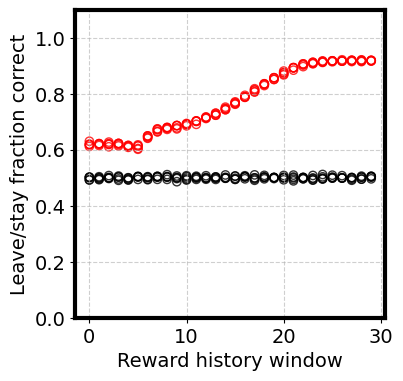

In [92]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    for reward_hist_size in range(0, 30):
        kf = KFold(n_splits=5, shuffle=True)
        pred_accuracies = []
        shuffled_pred_accuracies = []
        for train_i, test_i in kf.split(covariates, y):
            classifier = LogisticRegression(max_iter=int(1e6))
            reg = classifier.fit(covariates[train_i, :reward_hist_size + 1], y[train_i])
            pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y[test_i]))
            # do regression with shuffled labels
            y_test = y[test_i]
            np.random.shuffle(y_test)
            shuffled_pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y_test))

    
        axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
        axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [32]:
covariates = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]

        reward_history = []
        for i in range(len(trajs_for_patch_type)):
            curr_traj = trajs_for_patch_type[i]

            reward_site_idx = session_data['reward_site_idx'][curr_traj][0]

            if reward_site_idx == 0:
                reward_history = []

            attempted = session_data['current_reward_site_attempted'][curr_traj].sum() > 0
            reward = session_data['reward'][curr_traj].sum()
            if len(reward_history) > 29:
                reward_history = reward_history[:30]
            reward_history_vec = np.concatenate([np.array(reward_history), np.zeros(30 - len(reward_history))]).sum()

            covariates.append(np.concatenate([
                [session_data['current_patch_num'][curr_traj][0]],
                [reward_history_vec],
            ]))
            
            targets.append(attempted)
            reward_history.insert(0, reward)

covariates = np.stack(covariates)
targets = np.array(targets).reshape((len(targets), 1)).astype(int)

sampler = RandomUnderSampler()
covariates, targets = sampler.fit_resample(covariates, targets)
targets = targets.reshape(targets.shape[0], 1)

print(covariates.shape)
print(targets.shape)

(94582, 2)
(94582, 1)


(0.0, 1.1)

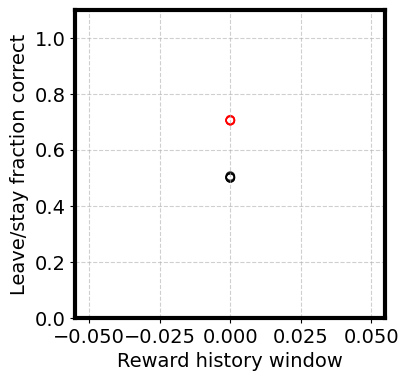

In [33]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    for reward_hist_size in range(0, 1):
        kf = KFold(n_splits=5, shuffle=True)
        pred_accuracies = []
        shuffled_pred_accuracies = []
        for train_i, test_i in kf.split(covariates, y):
            classifier = LogisticRegression(max_iter=int(1e6))
            reg = classifier.fit(covariates[train_i, :reward_hist_size + 1], y[train_i])
            pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y[test_i]))
            # do regression with shuffled labels
            y_test = y[test_i]
            np.random.shuffle(y_test)
            shuffled_pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y_test))

    
        axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
        axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [74]:
covariates = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]

        reward_history = []
        for i in range(len(trajs_for_patch_type)):
            curr_traj = trajs_for_patch_type[i]

            attempted = session_data['current_reward_site_attempted'][curr_traj].sum() > 0
            covariates.append(data[curr_traj, env_idx, :][0, :])
            targets.append(attempted)

covariates = np.stack(covariates)
targets = np.array(targets).reshape((len(targets), 1)).astype(int)

sampler = RandomUnderSampler()
covariates, targets = sampler.fit_resample(covariates, targets)
targets = targets.reshape(targets.shape[0], 1)

print(covariates.shape)
print(targets.shape)

(94582, 128)
(94582, 1)


(0.0, 1.1)

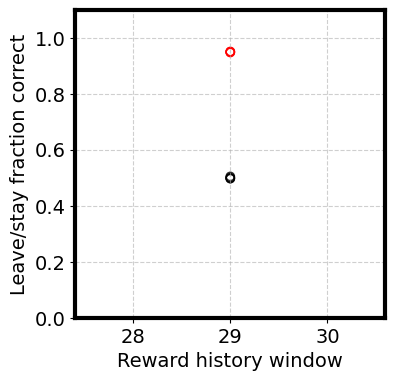

In [75]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    kf = KFold(n_splits=5, shuffle=True)
    pred_accuracies = []
    shuffled_pred_accuracies = []
    for train_i, test_i in kf.split(covariates, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(covariates[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(covariates[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(covariates[test_i, :], y_test))


    axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [25]:
data = load_numpy('../../results/rl_agent_outputs/acc_reward_test_line_init_01_2025-02-12_12_46_20_484517_var_noise_0_activity_weight_0/hidden_state/*.npy')
all_session_data = parse_session('../../results/rl_agent_outputs/acc_reward_test_line_init_01_2025-02-12_12_46_20_484517_var_noise_0_activity_weight_0/state')
all_session_data = np.array(all_session_data)
print(all_session_data.shape)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
(210,)


In [28]:
hidden_states = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                hidden_states.append(data[curr_traj, env_idx, :])
                targets.append(np.array([
                    session_data['reward_site_idx'][curr_traj],
                    session_data['rewards_seen_in_patch'][curr_traj],
                    session_data['patch_reward_param'][curr_traj],
                ]))

hidden_states = np.concatenate(hidden_states, axis=0)
targets = np.concatenate(targets, axis=1).T

first_site_hidden_states = []
first_site_targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data, first_site_only=True)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                first_site_hidden_states.append(data[curr_traj, env_idx, :])
                first_site_targets.append(np.array([
                    session_data['patch_reward_param'][curr_traj],
                ]))

first_site_hidden_states = np.concatenate(first_site_hidden_states, axis=0)
first_site_targets = np.concatenate(first_site_targets, axis=1).T

[-0.7233120686739329, -0.6327817079158518, -0.6730035315358289, -0.902053628005141, -0.9346115728605269]
[-0.7183670066070518, -0.6593893129224582, -0.6898721668205738, -0.8075828070143689, -0.8929539910189073]
[0.40668880626646936, 0.4079161101685738, 0.41221911379839365, 0.4098366573413952, 0.4107210540564931]
[0.3833491380358402, 0.39047341162739807, 0.38206044690835705, 0.3851578077128824, 0.3890482906190731]


(0.0, 1.1)

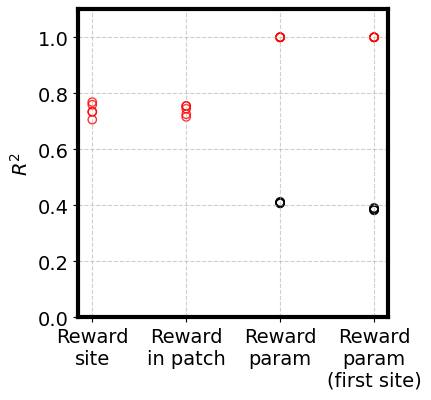

In [29]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

reg_types = [
    LinearRegression,
    LinearRegression,
    LogisticRegression,
]

for k in range(targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(hidden_states, y):
        # do normal regression
        if k == 2:
            classifier = reg_types[k](max_iter=int(1e6))
        else:
            classifier = reg_types[k]()
        reg = classifier.fit(hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(hidden_states[test_i, :], y_test))

    
    all_pred_accuracies.append(pred_accuracies)
    axs.scatter(np.ones(5) * k, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(np.ones(5) * k, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')

for k in range(first_site_targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = first_site_targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(first_site_hidden_states, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(first_site_hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y_test))

    all_pred_accuracies.append(pred_accuracies)
    x = np.ones(5) * k + targets.shape[1]
    axs.scatter(x, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(x, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel(r'$R^2$')
axs.set_xticks(np.arange(targets.shape[1] + first_site_targets.shape[1]))
axs.set_xticklabels([
    'Reward\nsite',
    'Reward\nin patch',
    'Reward\nparam',
    'Reward\nparam\n(first site)',
])
axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [30]:
print(data.shape)

(20000, 210, 128)


0
30
60
90
120
150
180


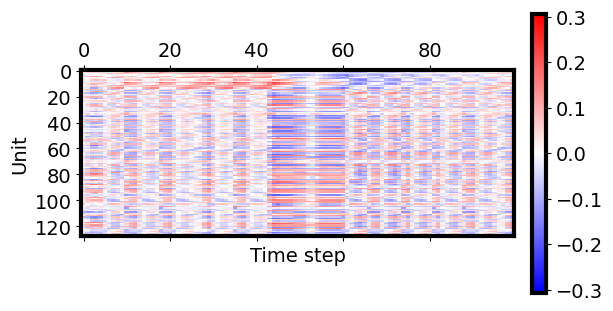

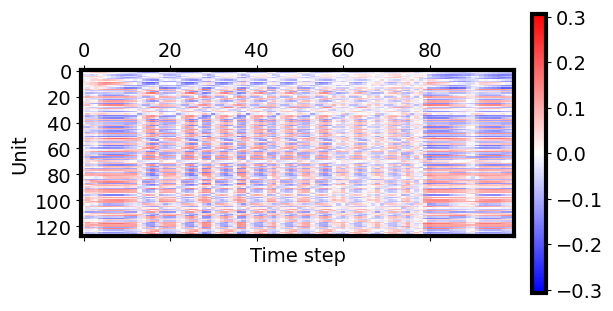

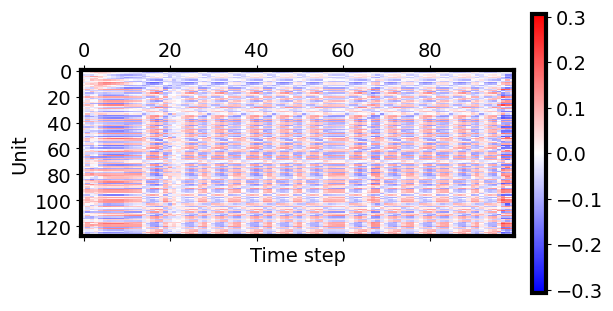

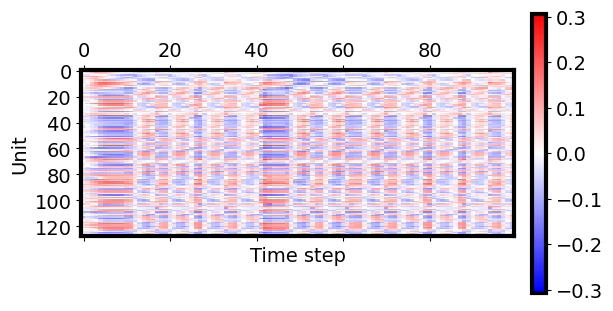

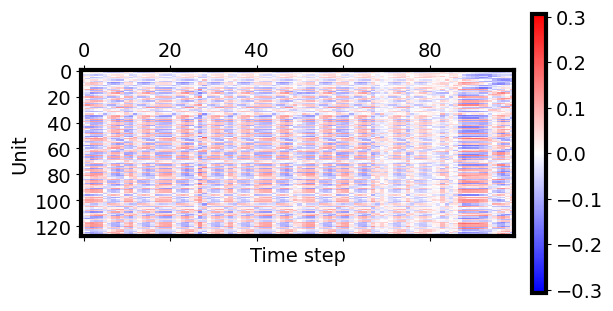

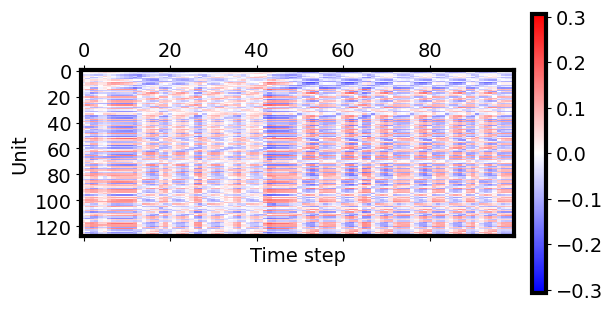

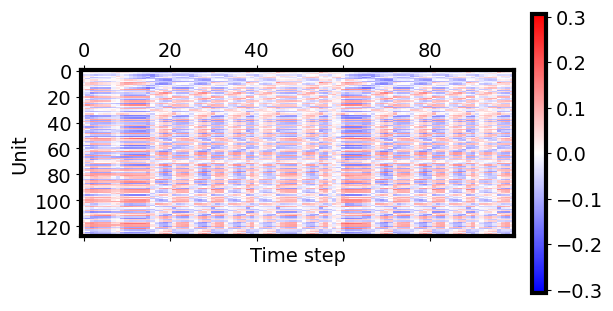

In [40]:
m = np.abs(data).max()


for k in range(0, 210, 30):
    print(k)
    hidden_activity = data[:100, k, :].T
    
    scale = 1.5
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
    axs.set_ylabel('Unit')
    axs.set_xlabel('Time step')

    cbar = axs.matshow(hidden_activity, vmin=-m, vmax=m, cmap='bwr', aspect=0.3)
    plt.colorbar(cbar, fraction=0.03, pad=0.04)

In [53]:
data = load_numpy('../../results/rl_agent_outputs/acc_reward_test_line_init_01_2025-02-12_13_10_17_431171_var_noise_0_activity_weight_0/hidden_state/*.npy')
all_session_data = parse_session('../../results/rl_agent_outputs/acc_reward_test_line_init_01_2025-02-12_13_10_17_431171_var_noise_0_activity_weight_0/state')
all_session_data = np.array(all_session_data)
print(all_session_data.shape)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
(210,)


In [54]:
hidden_states = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                hidden_states.append(data[curr_traj, env_idx, :])
                targets.append(np.array([
                    session_data['reward_site_idx'][curr_traj],
                    session_data['rewards_seen_in_patch'][curr_traj],
                    session_data['patch_reward_param'][curr_traj],
                ]))

hidden_states = np.concatenate(hidden_states, axis=0)
targets = np.concatenate(targets, axis=1).T

first_site_hidden_states = []
first_site_targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data, first_site_only=True)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                first_site_hidden_states.append(data[curr_traj, env_idx, :])
                first_site_targets.append(np.array([
                    session_data['patch_reward_param'][curr_traj],
                ]))

first_site_hidden_states = np.concatenate(first_site_hidden_states, axis=0)
first_site_targets = np.concatenate(first_site_targets, axis=1).T

[-0.9716950354322296, -0.9631687061717114, -0.9432391719930104, -0.9392976587334956, -0.9532625174500895]
[-0.9522821384074074, -0.9625688256302147, -0.9330000789544926, -0.9698705743738734, -0.9375794639263044]
[0.3867788026767951, 0.3836136733586544, 0.3862723819858926, 0.385845285680696, 0.38622510806851273]
[0.38892915863727173, 0.3867083907924048, 0.39056256850889287, 0.38822884622184506, 0.39303772851030727]


(0.0, 1.1)

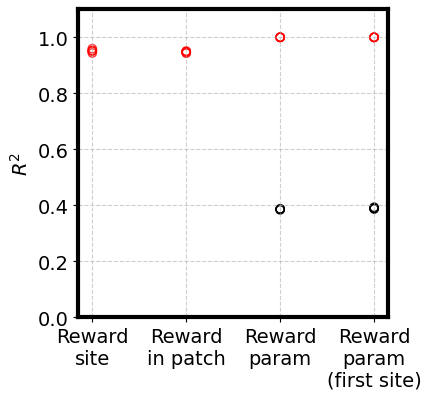

In [55]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

reg_types = [
    LinearRegression,
    LinearRegression,
    LogisticRegression,
]

for k in range(targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(hidden_states, y):
        # do normal regression
        if k == 2:
            classifier = reg_types[k](max_iter=int(1e6))
        else:
            classifier = reg_types[k]()
        reg = classifier.fit(hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(hidden_states[test_i, :], y_test))

    
    all_pred_accuracies.append(pred_accuracies)
    axs.scatter(np.ones(5) * k, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(np.ones(5) * k, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')

for k in range(first_site_targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = first_site_targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(first_site_hidden_states, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(first_site_hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y_test))

    all_pred_accuracies.append(pred_accuracies)
    x = np.ones(5) * k + targets.shape[1]
    axs.scatter(x, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(x, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel(r'$R^2$')
axs.set_xticks(np.arange(targets.shape[1] + first_site_targets.shape[1]))
axs.set_xticklabels([
    'Reward\nsite',
    'Reward\nin patch',
    'Reward\nparam',
    'Reward\nparam\n(first site)',
])
axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

(39514, 128)
[-0.9842050291386426, -0.8940617549457452, -0.9154257916357789, -0.9452964042597569, -0.8161813596503975]
(39514, 128)
[-0.8786105807690017, -0.8629139889877269, -0.9153656560545826, -0.9979701327198118, -0.9016885461022992]
(39514, 128)
[0.3870682019486271, 0.3842844489434392, 0.3815006959382513, 0.38592939390105024, 0.39749430523917995]
[0.3807640004944987, 0.3853857566765579, 0.3845202769535114, 0.39762611275964393, 0.38365479723046486]


(0.0, 1.1)

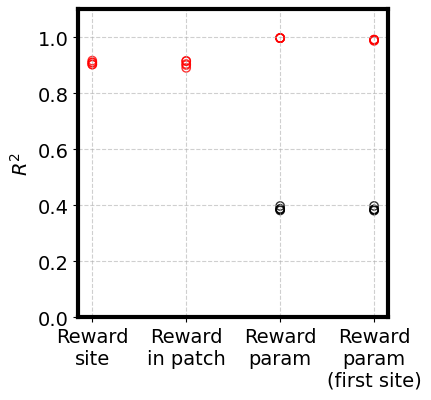

In [49]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

reg_types = [
    LinearRegression,
    LinearRegression,
    LogisticRegression,
]

hidden_states_pool = hidden_states[:, :15]
first_site_hidden_states_pool = first_site_hidden_states[:, :15]

for k in range(targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = targets[:, k]

    print(hidden_states.shape)
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(hidden_states_pool, y):
        # do normal regression
        if k == 2:
            classifier = reg_types[k](max_iter=int(1e6))
        else:
            classifier = reg_types[k]()
        reg = classifier.fit(hidden_states_pool[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(hidden_states_pool[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(hidden_states_pool[test_i, :], y_test))

    
    all_pred_accuracies.append(pred_accuracies)
    axs.scatter(np.ones(5) * k, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(np.ones(5) * k, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')

for k in range(first_site_targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = first_site_targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(first_site_hidden_states_pool, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(first_site_hidden_states_pool[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(first_site_hidden_states_pool[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(first_site_hidden_states_pool[test_i, :], y_test))

    all_pred_accuracies.append(pred_accuracies)
    x = np.ones(5) * k + targets.shape[1]
    axs.scatter(x, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(x, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel(r'$R^2$')
axs.set_xticks(np.arange(targets.shape[1] + first_site_targets.shape[1]))
axs.set_xticklabels([
    'Reward\nsite',
    'Reward\nin patch',
    'Reward\nparam',
    'Reward\nparam\n(first site)',
])
axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

(39514, 128)
[-0.9956043678531996, -0.91537393935111, -0.9659957959023617, -0.960300893570037, -0.883667643889618]
(39514, 128)
[-0.8834693994841201, -0.8964086975131418, -0.9445995142817536, -1.0191580165006493, -0.9610293074018401]
(39514, 128)
[0.3870682019486271, 0.3866885992661015, 0.38479058585347337, 0.3957990636467164, 0.37914452037458873]
[0.377673383607368, 0.38686943620178044, 0.3929277942631058, 0.38625123639960435, 0.3840257171117705]


(0.0, 1.1)

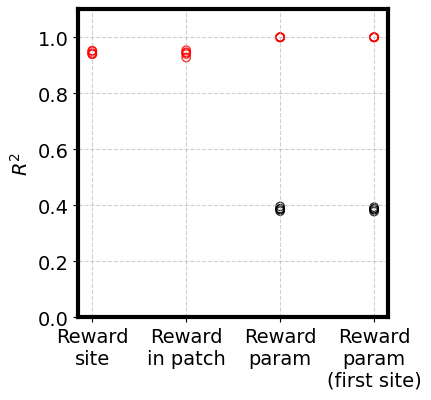

In [50]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

reg_types = [
    LinearRegression,
    LinearRegression,
    LogisticRegression,
]

hidden_states_pool = hidden_states[:, 15:]
first_site_hidden_states_pool = first_site_hidden_states[:, 15:]

for k in range(targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = targets[:, k]

    print(hidden_states.shape)
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(hidden_states_pool, y):
        # do normal regression
        if k == 2:
            classifier = reg_types[k](max_iter=int(1e6))
        else:
            classifier = reg_types[k]()
        reg = classifier.fit(hidden_states_pool[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(hidden_states_pool[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(hidden_states_pool[test_i, :], y_test))

    
    all_pred_accuracies.append(pred_accuracies)
    axs.scatter(np.ones(5) * k, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(np.ones(5) * k, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')

for k in range(first_site_targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = first_site_targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(first_site_hidden_states_pool, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(first_site_hidden_states_pool[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(first_site_hidden_states_pool[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(first_site_hidden_states_pool[test_i, :], y_test))

    all_pred_accuracies.append(pred_accuracies)
    x = np.ones(5) * k + targets.shape[1]
    axs.scatter(x, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(x, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel(r'$R^2$')
axs.set_xticks(np.arange(targets.shape[1] + first_site_targets.shape[1]))
axs.set_xticklabels([
    'Reward\nsite',
    'Reward\nin patch',
    'Reward\nparam',
    'Reward\nparam\n(first site)',
])
axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

0
3
6
9
12
15
18
21
24
27


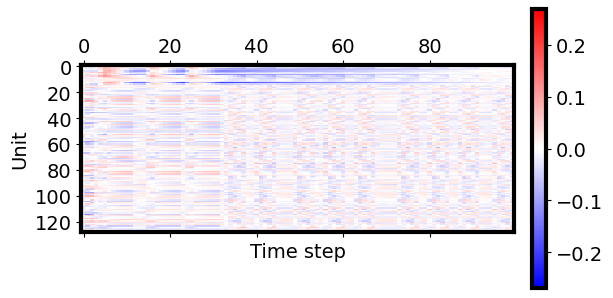

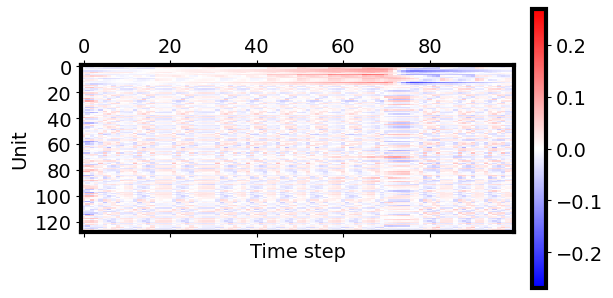

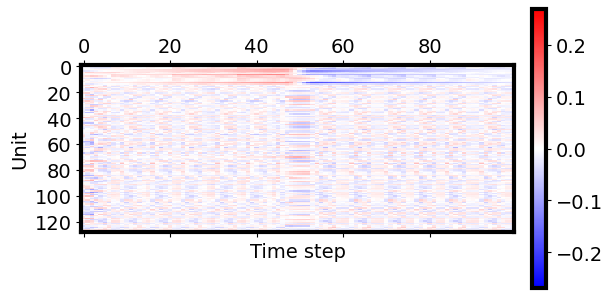

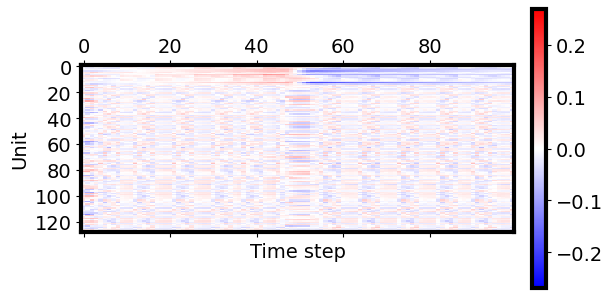

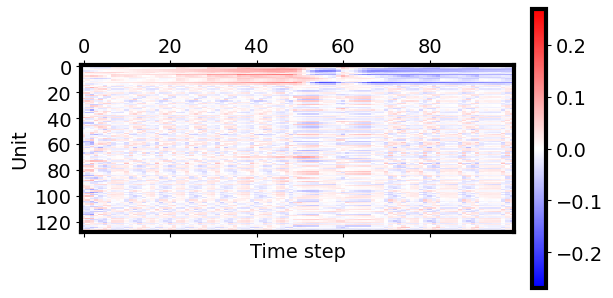

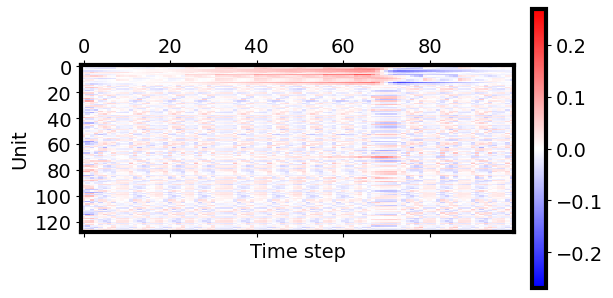

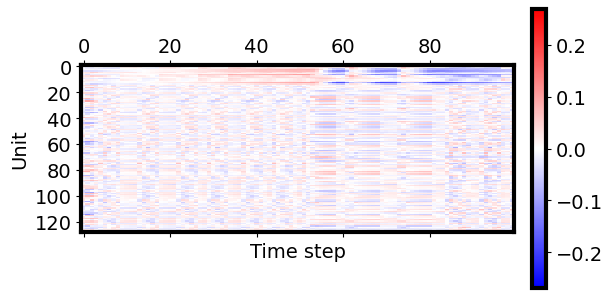

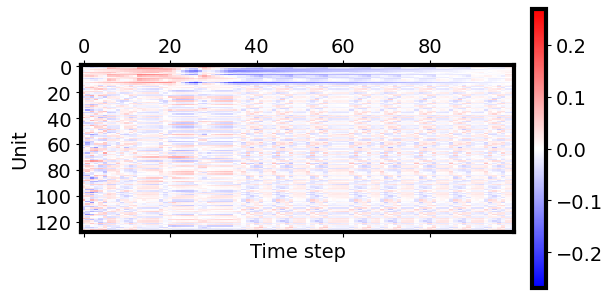

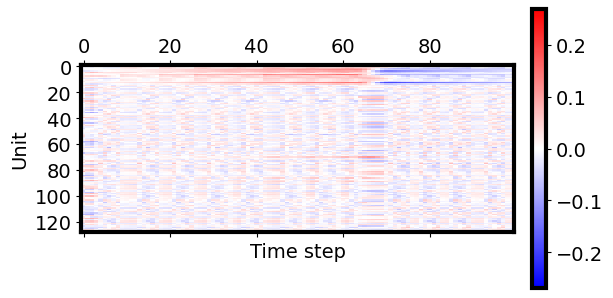

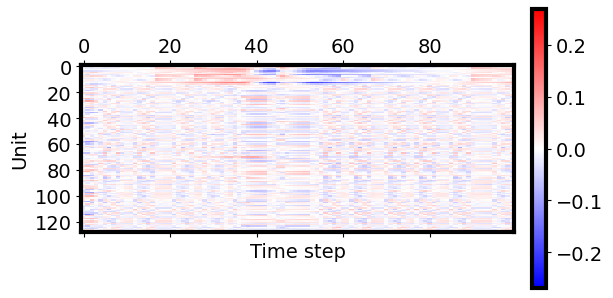

In [46]:
m = np.abs(data).max()


for k in range(0, 30, 3):
    print(k)
    hidden_activity = data[:100, k, :].T
    
    scale = 1.5
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
    axs.set_ylabel('Unit')
    axs.set_xlabel('Time step')

    cbar = axs.matshow(hidden_activity, vmin=-m, vmax=m, cmap='bwr', aspect=0.3)
    plt.colorbar(cbar, fraction=0.03, pad=0.04)

In [56]:
first_site_hidden_states = []
first_site_targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data, first_site_only=True)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                first_site_hidden_states.append(data[curr_traj, env_idx, :])
                first_site_targets.append(np.array([
                    session_data['rewards_seen_in_patch'][curr_traj],
                ]))

first_site_hidden_states = np.concatenate(first_site_hidden_states, axis=0)
first_site_targets = np.concatenate(first_site_targets, axis=1).T

[0.6318441383943567, 0.6303525335030586, 0.6329691312188395, 0.6320851455040487, 0.6297691029312966]


(0.0, 1.1)

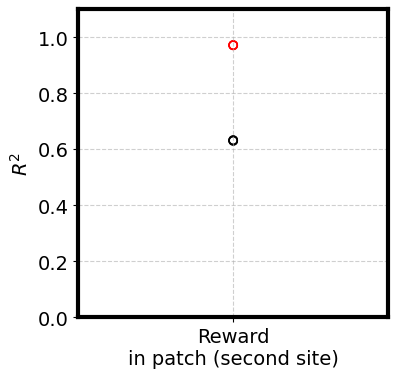

In [57]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(first_site_targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = first_site_targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(first_site_hidden_states, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(first_site_hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y_test))

    all_pred_accuracies.append(pred_accuracies)
    x = np.ones(5) * k
    axs.scatter(x, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(x, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel(r'$R^2$')
axs.set_xticks(np.arange(first_site_targets.shape[1]))
axs.set_xticklabels([
    'Reward\nin patch (second site)',
])
axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)